In [1]:
# %pip install tensorflow==2.4.1
# %pip install transformers
# %pip install pyarrow
# %pip install tensorflow-addons

In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import os
import tensorflow_addons as tfa
from math import ceil
from tensorflow.keras.utils import plot_model
from transformers import RobertaTokenizer, RobertaTokenizerFast, TFRobertaModel, TFAlbertModel

AUTO = tf.data.experimental.AUTOTUNE

In [2]:
model_iteration = 'iteration_final/funnel_transformer'

In [3]:
with open(f"./{model_iteration}/vocab/topics_vocab.pkl", "rb") as f:
    target_vocab = pickle.load(f)
    
target_vocab_inv = {j:i for i,j in target_vocab.items()}

with open(f"./{model_iteration}/vocab/doc_type_vocab.pkl", "rb") as f:
    doc_vocab = pickle.load(f)
    
doc_vocab_inv = {j:i for i,j in doc_vocab.items()}

with open(f"./{model_iteration}/vocab/journal_name_vocab.pkl", "rb") as f:
    journal_vocab = pickle.load(f)
    
journal_vocab_inv = {j:i for i,j in journal_vocab.items()}

In [4]:
encoding_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
    max_tokens=len(target_vocab)+1, output_mode="binary", sparse=False)

# # loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
# loss_fn = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0, 
#                                               reduction=tf.keras.losses.Reduction.NONE)

# metric_1 = tf.keras.metrics.CategoricalAccuracy()
# metric_2 = tf.keras.metrics.Recall()
# metric_3 = tf.keras.metrics.Precision()
# metric_4 = tf.keras.metrics.TopKCategoricalAccuracy(K=10)
# # Eventually will use with focal loss


In [6]:
# test_data = pd.read_parquet("./iteration_1/tokenized_data/test/part-00000-tid-2414260718030245702-c767428a-156f-4065-8c31-91dc1cd77c46-6816-1-c000.snappy.parquet").sample(3000)
# test_data.shape

In [7]:
# test_data.head(5)

In [5]:
mag_model = tf.keras.models.load_model(f'./{model_iteration}/models/partial_model20211104_lr001_beta060_gamma10_nH4_nL1_thresh035/model_epoch09ckpt/')

2021-11-05 12:16:09.882619: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-05 12:16:09.882838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
mag_model.summary()

Model: "mag_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
paper_title_ids (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 512, 768)     23441664    paper_title_ids[0][0]            
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 512, 768)     0           title_embedding[0][0]            
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 512, 768)     2362368     tf.__operators__.add[0][0]       
                                                                 tf.__operators__.add[0][0

In [6]:
final_model = tf.keras.Model(inputs=mag_model.inputs, 
                             outputs=tf.math.top_k(mag_model.outputs, k=30))

In [7]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
paper_title_ids (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 512, 768)     23441664    paper_title_ids[0][0]            
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 512, 768)     0           title_embedding[0][0]            
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 512, 768)     2362368     tf.__operators__.add[0][0]       
                                                                 tf.__operators__.add[0][0]   

In [11]:
def get_all_model_predictions(data_path):
    # Get all of the files, load into single pandas dataframe
    # split up into blocks of 3000 and get model output
    file_names = [x for x in os.listdir(f"./{model_iteration}/tokenized_data/test/") if x.startswith('part')]
    file_names.sort()
    
    full_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_df = pd.read_parquet(f"./{model_iteration}/tokenized_data/test/{file_name}")
        full_df = pd.concat([full_df, temp_df], axis=0)
    
    num_samples = 1000
    preds_final = []
    scores_final = []
    for i in range(ceil(full_df.shape[0]/num_samples))[:1]:
        print(i)
        small_df = full_df.iloc[i*num_samples:(i+1)*num_samples, :].copy()
        preds, scores = get_model_predictions(small_df)
        preds_final += preds
        scores_final += scores
        
    full_df = full_df.head(1000).copy()
    
    full_df['predictions'] = preds_final
    full_df['scores'] = scores_final
    
    return full_df


In [12]:
def get_model_predictions(input_data):
    
    paper_titles = tf.keras.preprocessing.sequence.pad_sequences(input_data['paper_title_tok'].to_list(), maxlen=512, 
                                                             dtype='int64', padding='post', 
                                                             truncating='post', value=0)
    
#     paper_titles_masks = tf.keras.preprocessing.sequence.pad_sequences(input_data['paper_title_mask'].to_list(), maxlen=512, 
#                                                                    dtype='int64', padding='post', 
#                                                                    truncating='post', value=0)
    
    doc_types = tf.convert_to_tensor(input_data['doc_type_tok'].to_list())
    journal = tf.convert_to_tensor(input_data['journal_tok'].to_list())
    
    model_output = final_model([paper_titles, doc_types, journal])
    
    scores = model_output.values.numpy()[0][:,:20].tolist()
    preds = model_output.indices.numpy()[0][:,:20].tolist()
    
    return preds, scores

In [15]:
test_input_data = test_data.head(3).copy()

In [16]:
test_paper = tf.keras.preprocessing.sequence.pad_sequences(test_input_data['paper_title_tok'].to_list()[:1], maxlen=512, 
                                                             dtype='int64', padding='post', 
                                                             truncating='post', value=0)

In [18]:
test_doc_types = tf.convert_to_tensor(test_input_data['doc_type_tok'].to_list()[:1])
test_journal = tf.convert_to_tensor(test_input_data['journal_tok'].to_list()[:1])

In [20]:
final_model([test_paper, test_doc_types, test_journal]).indices.numpy()[0][:,:20].tolist()

[[1,
  27,
  113,
  437,
  216,
  4,
  2252,
  1155,
  7,
  567,
  120,
  152,
  552,
  30,
  23,
  8899,
  789,
  3,
  5,
  251]]

In [13]:
test_data = get_all_model_predictions(f"./{model_iteration}/tokenized_data/test/")

0


In [14]:
# test_data.to_parquet(f"./{model_iteration}/test_data/data_with_predictions.parquet")

In [15]:
test_data = pd.read_parquet(f"./{model_iteration}/test_data/data_with_predictions.parquet")
test_data['target_test'] = test_data['target_tok'].apply(lambda x: [i for i in x if i!=-1])
test_data['target_test'] = test_data['target_test'].apply(len)
test_data = test_data[test_data['target_test'] > 0].copy()

In [14]:
test_data.head(5)

,paper_id,publication_date,doc_type_tok,journal_tok,target_tok,paper_title_tok,paper_title_mask,predictions,scores
0,9881621,2001-01-01,[2],[2],"[46048, 105, 24]","[101, 27294, 8092, 1999, 2137, 15030, 5283, 102]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 27, 113, 437, 216, 4, 2252, 1155, 7, 567, ...","[0.4334312677383423, 0.26733309030532837, 0.22..."
1,39454049,2011-06-01,[4],[2],"[18799, 175, 1777, 2486, 4, 113, 80]","[101, 2309, 2224, 12702, 10258, 21272, 2594, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 437, 27, 36, 23, 22, 26, 1155, 4, 9, 120, ...","[0.4305480718612671, 0.3231326937675476, 0.266..."
2,46834813,1974-10-01,[2],[2],"[199, 1065, 183, 21627, 7, 2161, 4441, 6444, 4...","[101, 1037, 2817, 1997, 1996, 1047, 2692, 1048...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 27, 113, 216, 4, 437, 2252, 1155, 7, 567, ...","[0.43141621351242065, 0.27147382497787476, 0.2..."
3,75469766,1974-01-01,[2],[2],"[13594, 293, 882, 945, 6887, 2049, 7, 10494]","[101, 1996, 2535, 1997, 14784, 1055, 27885, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 27, 113, 216, 437, 4, 2252, 1155, 7, 567, ...","[0.4223536252975464, 0.2649972438812256, 0.234..."
4,129658366,2002-01-01,[2],[2],"[341, 18, 7125, 1298, 297, 16198, 1216, 3702, ...","[101, 1996, 9710, 1997, 4800, 2303, 11643, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 27, 113, 216, 4, 437, 2252, 1155, 7, 567, ...","[0.43038231134414673, 0.2719365358352661, 0.23..."


### Putting Everything Together

In [19]:
def get_metrics(data, target_col, predict_col):
    targets = tf.keras.preprocessing.sequence.pad_sequences(data[target_col].to_list(), maxlen=20, 
                                                            dtype='int64', padding='post', 
                                                            truncating='post', value=0)
    targets = tf.RaggedTensor.from_tensor(targets, padding=0)
    targets = encoding_layer(targets)
    
    predictions = tf.keras.preprocessing.sequence.pad_sequences(data[predict_col].to_list(), maxlen=30, 
                                                                dtype='int64', padding='post', 
                                                                truncating='post', value=0)
    predictions = tf.RaggedTensor.from_tensor(predictions, padding=0)
    predictions = encoding_layer(predictions)
    
    recall_score = tf.keras.metrics.Recall()
    precision_score = tf.keras.metrics.Precision()
    
    recall_score.update_state(targets,predictions)
    precision_score.update_state(targets,predictions)
    
    print(f"Recall: {round(recall_score.result().numpy()*100, 1)}%")
    print(f"Precision: {round(precision_score.result().numpy()*100, 1)}%")

In [ ]:
get_metrics(test_data, 'target_tok', 'predictions')

### Quick Sample of Targets vs Predictions

In [ ]:
sample_data = test_data.sample(10)
for i,j in zip(sample_data['target_tok'].to_list(),sample_data['predictions'].to_list()):
    print("Targets:")
    print([target_vocab_inv.get(x) for x in i])
    print("\n")
    print("Predictions:")
    print([target_vocab_inv.get(x) for x in j])
    print("-----------------------------------------------------------------------------")
    print("\n")

In [ ]:
for i,j in target_vocab_inv.items():
    if i < 50:
        print(f"{i}: {j}")

In [ ]:
level_ones = [2,3,4,5,6,7,11,12,13,14,16,18,19,21,24,29,32]

### Get metrics for different levels

In [ ]:
# need to get df that contains the tag and the appropriate level (get only tags that show up in vocab)
# also need to match up the tag with the tag_id from the vocab

In [ ]:
levels_df = pd.read_parquet("./test_data_files/tag_levels.parquet").fillna(6)
levels_df['level'] = levels_df['level'].astype('int')
# levels_df = pd.DataFrame(zip(level_ones, [1]*len(level_ones)), columns=['tag','level'])

In [ ]:
levels_df['level'].value_counts()

In [ ]:
def get_df_for_specific_level(old_df, levels, level_to_get=1):
    df = old_df.copy()
    tags_list = levels[levels['level']==level_to_get]['topic_name'].to_list()
    tags_id_list = [target_vocab.get(x) for x in tags_list]
    print(f"Number of Level {level_to_get} Tags: {len(tags_list)}")
    
    df[f'tags_level_{level_to_get}'] = df['target_tok'].apply(lambda x: [i for i in x if i in tags_id_list])
    df[f'preds_level_{level_to_get}'] = df['predictions'].apply(lambda x: [i for i in x if i in tags_id_list])
    
    df[f'tag_level_{level_to_get}_len'] = df[f'tags_level_{level_to_get}'].apply(len)
    df[f'pred_level_{level_to_get}_len'] = df[f'preds_level_{level_to_get}'].apply(len)
    
    papers_with_tag = (df[df[f'tag_level_{level_to_get}_len'] > 0].shape[0])/df.shape[0]
    papers_with_pred = (df[df[f'pred_level_{level_to_get}_len'] > 0].shape[0])/df.shape[0]
    
    print(f"Percentage of papers with Level {level_to_get} Tags: {round(papers_with_tag*100, 1)}")
    print(f"Percentage of papers with Level {level_to_get} Preds: {round(papers_with_pred*100, 1)}")
    
    return df

In [ ]:
level_to_check = 0
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 1
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 2
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 3
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 4
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 5
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 6
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

### Looking into Data Available vs Not Available

In [42]:
test_data['journal'] = test_data['journal_tok'].apply(lambda x: [journal_vocab_inv.get(i) for i in x][0])
test_data['doc_type'] = test_data['doc_type_tok'].apply(lambda x: [doc_vocab_inv.get(i) for i in x][0])

In [49]:
test_data.head(1)

,paper_id,publication_date,doc_type_tok,journal_tok,target_tok,paper_title_tok,paper_title_mask,predictions,scores,journal,doc_type,paper_title_tok_len
16657,2604922879,2001-11-28,[4],[2],[2],"[2, 2494, 5036, 43, 2373, 2110, 203, 14923, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4, 2, 157, 87, 78, 10, 28, 286, 167, 339, 48,...","[0.6048187017440796, 0.3559792637825012, 0.291...",[NONE],Patent,47


In [47]:
test_data['doc_type'].value_counts().index

Index(['Journal', 'Patent', '[NONE]', 'Conference', 'Repository', 'Thesis',
       'Book', 'BookChapter'],
      dtype='object')

##### Different Doc Types

In [52]:
for doc_type in test_data['doc_type'].value_counts().index:
    print(doc_type)
    get_metrics(test_data[test_data['doc_type']==doc_type], "target_tok", "predictions")
    print("-----------------------------------------------------------------------")
    print("\n")

Journal
Recall: 49.2%
Precision: 27.9%
-----------------------------------------------------------------------


Patent
Recall: 48.3%
Precision: 24.3%
-----------------------------------------------------------------------


[NONE]
Recall: 51.5%
Precision: 21.0%
-----------------------------------------------------------------------


Conference
Recall: 45.7%
Precision: 28.6%
-----------------------------------------------------------------------


Repository
Recall: 45.7%
Precision: 25.8%
-----------------------------------------------------------------------


Thesis
Recall: 52.6%
Precision: 24.1%
-----------------------------------------------------------------------


Book
Recall: 57.6%
Precision: 20.7%
-----------------------------------------------------------------------


BookChapter
Recall: 68.4%
Precision: 17.3%
-----------------------------------------------------------------------




##### Journal vs No Journal

### Looking into Journal Title Length

In [48]:
test_data['paper_title_tok_len'] = test_data['paper_title_tok'].apply(len)

<AxesSubplot:ylabel='Frequency'>

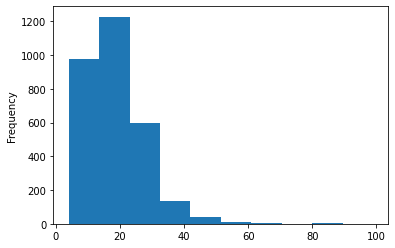

In [50]:
test_data['paper_title_tok_len'].plot.hist()

In [ ]:
# 0 - 20, 20 - 40, 40+